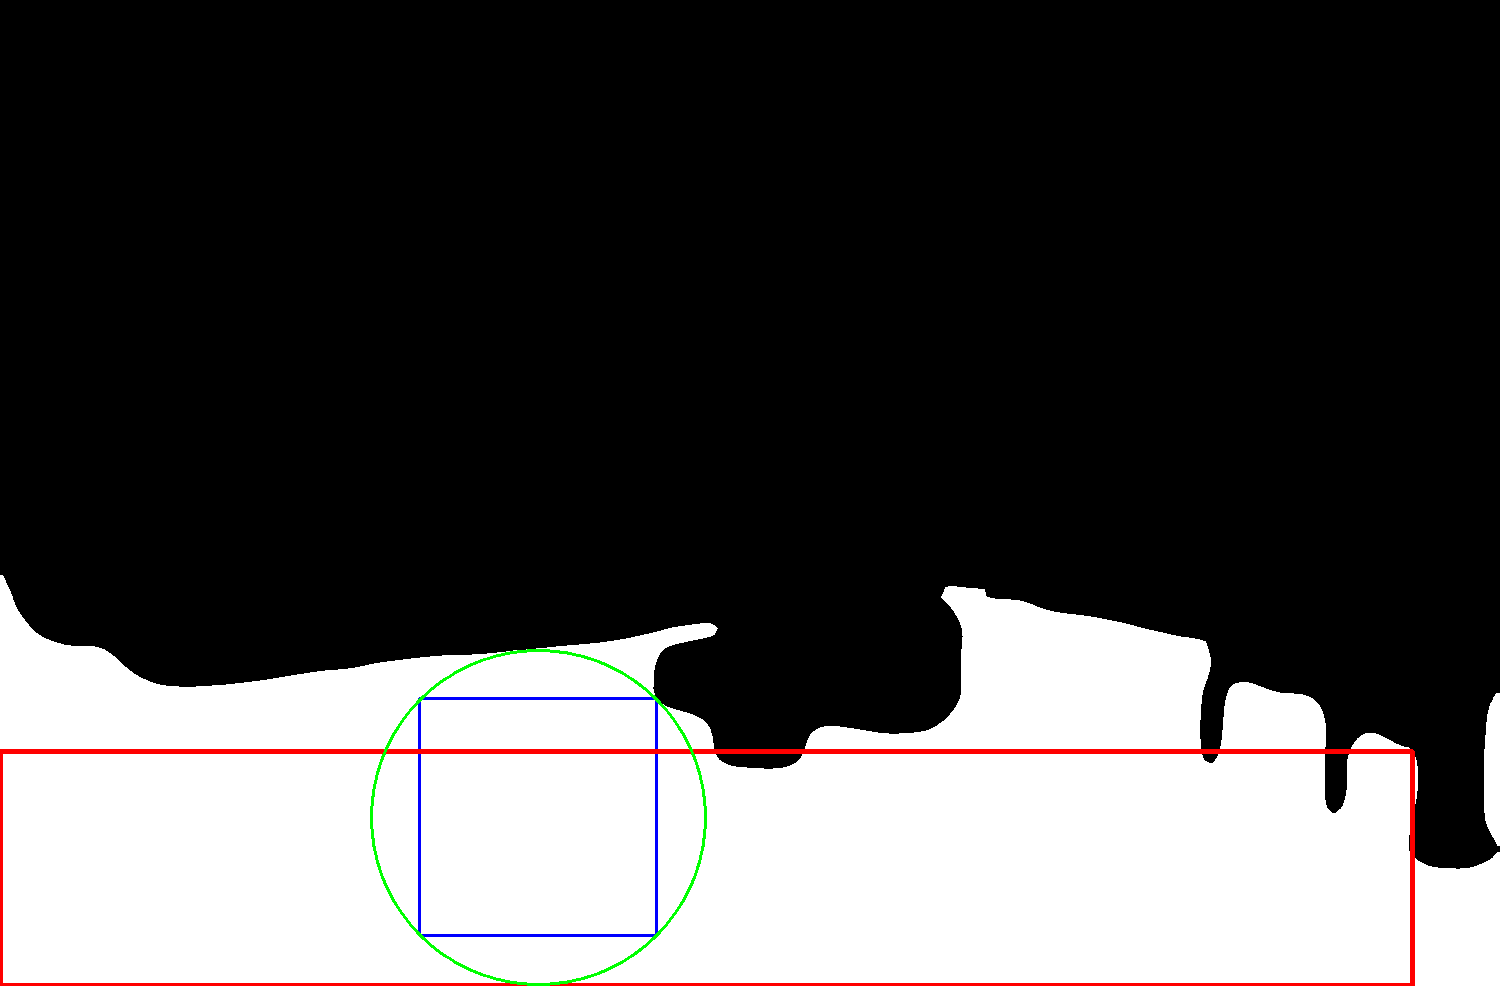

In [15]:

import os
import cv2
import PIL
import math
import pathlib
import numpy as np
from glob import glob
from PIL import Image



def show_img(img):
    cv2.namedWindow("img", cv2.WINDOW_NORMAL)
    cv2.imshow('img', img)
    cv2.waitKey()


def inner_rect(pts):
    # 左下角的点具有最大的差值
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    del pts,s
    return rect


def mask_inner_shape(mask_bin, crop_size=224, is_show=True):
    """ 最大内接圆  和 最大内接正方形 及 最大内接矩形 """

    ## 获取最大内接圆，根据内接圆半径退出正方形边长即可
    h, w = mask_bin.shape
    area_threshold = 100 * 100
    dist = np.empty((h, w), dtype=np.float32)
    _, thresh = cv2.threshold(mask_bin, 0, 255, cv2.THRESH_BINARY)
    bin = thresh.copy()
    contours, hierarchy = cv2.findContours(bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    filter_contours = list(filter(lambda x: cv2.contourArea(x) > area_threshold, contours))
    # show_img(mask_bin)
    ## 最大内接圆、最大内接正方形

    if len(filter_contours) == 0:
        return np.array([]), (100, 100)
    for i in range(h):
        for j in range(w):
            dist[i, j] = cv2.pointPolygonTest(filter_contours[0], (j, i), True)
    minVal, maxVal, _, maxDistPt = cv2.minMaxLoc(dist)
    maxVal = abs(maxVal)
    cx, cy = maxDistPt
    r = np.int(maxVal)
    rect_size = math.sqrt(2 * r * r)
    rect_size = crop_size if int(rect_size) > rect_size else rect_size
    x1, x2 = int(cx - rect_size / 2), int(cx + rect_size / 2)
    y1, y2 = int(cy - rect_size / 2), int(cy + rect_size / 2)
    
    c = contours[0] ## 最大轮廓
    rect = inner_rect(c.reshape(c.shape[0], 2))
    xs = sorted([i[0] for i in rect])
    ys = sorted([i[1] for i in rect])
    rect_x1 = int(xs[1])
    rect_x2 = int(xs[2])
    rect_y1 = int(ys[1])
    rect_y2 = int(ys[2])

    result = mask_bin
    if is_show:
        result = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(result, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.rectangle(result, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 255), 4)
        cv2.circle(result, (cx, cy), r, (0, 255, 0), 2, 1, 0)
    
    return cv2_pilimg(result)



def cv2_pilimg(cv2_img):
	""" opencv --> PIL """
	return PIL.Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))



mask = cv2.imread("./mask.png")
mask_bin = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask_inner_shape(mask_bin)